In [2]:
import nidaqmx
import numpy as np
import matplotlib.pyplot as plt

In [3]:
undershoot = 10
pixelsPerLine = 100
linesPerFrame = 100
X_RETRACE_LEN = 128

def SplineInterpolate(n, yFirst, yLast, slopeFirst, slopeLast):
    m = float(n)
    mm = float(m * m)
    mmm = float(m * m *m)
    c = []
    c.append(slopeFirst / mm + 2.0 * yFirst / mmm + slopeLast / mm - 2.0 * yLast / mmm)
    c.append(3.0 * yLast / mm - slopeLast / m - 2.0 * slopeFirst / m - 3.0 * yFirst / mm)
    c.append(slopeFirst)
    c.append(yFirst)
    
    result = []
    n = int(n)
    for i in range(n):
        result.append(c[0] * i*i*i + c[1] * i*i + c[2] * i + c[3])
    return result

def GenerateXWaveform(scanLen, retraceLen, undershootLen, scanStart, scanEnd):
    waveform = []
    scanAmp = scanEnd - scanStart
    step = scanAmp/scanLen
    linearLen = undershootLen + scanLen
    undershootStart = scanStart - undershootLen * step
    
    for i in range(linearLen):
        val = undershootStart + step * i
        waveform.append(val)
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, undershootStart, step, step)
        completeWaveform = waveform + splineWaveform
    return completeWaveform

def GenerateYWaveform(linesPerFrame, retraceLen, xLength, scanStart, scanEnd):
    scanAmp = scanEnd - scanStart
    step = scanAmp/linesPerFrame
    waveform = np.zeros(linesPerFrame * xLength)
    
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, scanStart, 0, 0)
    for j in range(linesPerFrame):
        for i in range(xLength):
            waveform[i + j * xLength] = scanStart + step * j
            nextIndex = i + j * xLength
            if j >= (linesPerFrame - 1) and i >= (xLength - X_RETRACE_LEN):
                break
    
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, scanStart, 0, 0)
        for i in range(X_RETRACE_LEN):
            waveform[nextIndex + i] = splineWaveform[i]
    return waveform

def GenerateGalvoFrame(width, height, resolution, zoom, undershoot, xOffset, yOffset, galvoX, galvoY):
    xStart = (-0.5 * resolution + xOffset) / (zoom * resolution)
    yStart = (-0.5 * resolution + yOffset) / (zoom * resolution)
    xEnd = xStart + pixelsPerLine / (zoom * resolution)
    yEnd = yStart + linesPerFrame / (zoom * resolution)
    
    offsetXinDegree = galvoX / 3.0
    offsetYinDegree = galvoY / 3.0
    xLength = undershoot + pixelsPerLine + X_RETRACE_LEN
    yLength = linesPerFrame
    
    xWaveformFrame = GenerateXWaveform(pixelsPerLine, X_RETRACE_LEN, undershoot, xStart, xEnd)
    yWaveformFrame = GenerateYWaveform(linesPerFrame, X_RETRACE_LEN, xLength, yStart, yEnd)
    waveformFrame = np.zeros(2 * xLength * yLength)
    fullXWaveformFrame = []
    for j in range(yLength):
        for i in range(xLength):
            waveformFrame[i + j * xLength] = (xWaveformFrame[i] + offsetXinDegree)
            waveformFrame[i + j * xLength + yLength * xLength] = (yWaveformFrame[i + j * xLength] + offsetYinDegree)
    return waveformFrame
                

In [16]:
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, 100, 1, undershoot, 0, 0, 0, 0)
frameLength = len(frame)

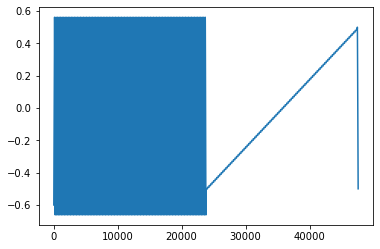

In [17]:
frame2 = frame[:1000]
plt.plot(frame)

23800.0


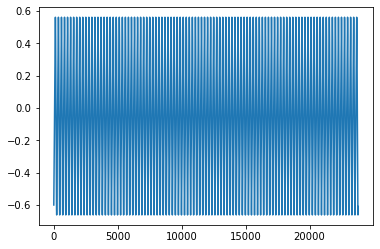

In [18]:
print(frameLength/2)
xFrame = frame[:int(frameLength / 2)]
plt.plot(xFrame)

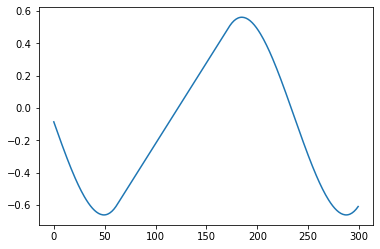

In [19]:
plt.plot(xFrame[23500:])

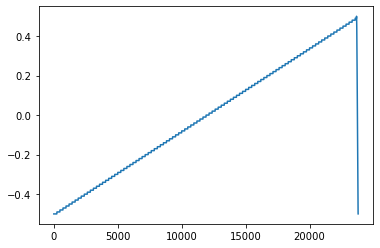

In [20]:
yFrame = frame[int(frameLength / 2):]
plt.plot(yFrame)

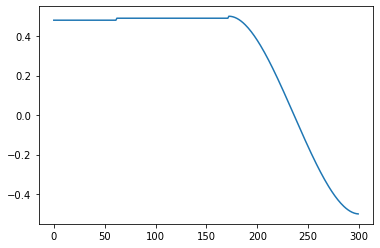

In [21]:
plt.plot(yFrame[23500:])

In [22]:
x = [-1, -.9, -.8, -.7, -.6, -.5, -.4, -.3, -.2, -.1, 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
y = [-.9985, -.9015, -.8005, -.6995, -.5995, -.5002, -.4007, -.3006, -.2009, -.1002, -.0001, .0979, .1992, .3005, .3970, .4993, .5978, .7010, .7997, .8996, .9999]


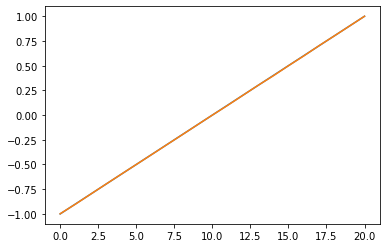

In [24]:
plt.plot(x)
plt.plot(y)